<a href="https://colab.research.google.com/github/GabrielHaveroth/deep_egomotion_radar_heatmap/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
!cd drive
!ls

drive  sample_data


In [ ]:
# Loading dataset
# import numpy as np
# y = np.load('/content/drive/My Drive/Mestrado/Coloradar/data/delta_poses.npy')
# heatmaps = np.load('/content/drive/My Drive/Mestrado/Coloradar/data/heatmap.npy')
# imu_data = np.load('/content/drive/My Drive/Mestrado/Coloradar/data/imu.npy')


In [11]:
%cd /content/drive/My Drive/Mestrado/Coloradar/data
%ls

/content/drive/My Drive/Mestrado/Coloradar/data
delta_poses.npy  models/                    test.tfrecords
heatmap.npy      scaler_2D_delta_poses.pkl  train.tfrecords
imu.npy          scaler_6D_delta_poses.pkl  val.tfrecords
logs/            test.pkl


In [16]:
# tf record helpers
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16
EPOCHS = 100

# MAX and MIN POWER
MAX_POWER = 4815355.5
MIN_POWER = 0.01419168058782816
MAX_DOPPLER = 1.1527502536773682
MIN_DOPPLER = -1.317428708076477

def decode_heatmap(hm_bytes):
    frame_vals = tf.io.decode_raw(hm_bytes, little_endian=True, out_type=tf.float32)
    frame = tf.reshape(frame_vals, (32, 128, 128, 2))[:, :, :, 0]
    return frame

def read_tfrecord(example):
    feature_description = {'heatmap1': tf.io.FixedLenFeature([], tf.string),
                           'heatmap2': tf.io.FixedLenFeature([], tf.string),
                           'delta_roll': tf.io.FixedLenFeature([], tf.float32),
                           'delta_pitch': tf.io.FixedLenFeature([], tf.float32),
                           'delta_yaw': tf.io.FixedLenFeature([], tf.float32),
                           'delta_x': tf.io.FixedLenFeature([], tf.float32),
                           'delta_y': tf.io.FixedLenFeature([], tf.float32),
                           'delta_z': tf.io.FixedLenFeature([], tf.float32)}
    example = tf.io.parse_single_example(example, feature_description)
    hm1 = (tf.reshape(decode_heatmap(example["heatmap1"]), ((32, 128, 128, 1))) - MIN_POWER) / (MAX_POWER - MIN_POWER)
    hm2 = (tf.reshape(decode_heatmap(example["heatmap2"]), ((32, 128, 128, 1))) - MIN_POWER) / (MAX_POWER - MIN_POWER)
    hm12 = tf.concat([hm1, hm2], -1)
    y_rot = tf.stack([example['delta_roll'], example['delta_pitch'], example['delta_yaw']])
    y_trans = tf.stack([example['delta_x'], example['delta_y'], example['delta_z']])
    return hm12, (y_trans, y_rot)

def load_dataset(filenames):
  ignore_order = tf.data.Options()
  ignore_order.experimental_deterministic = False  # disable order, increase speed
  dataset = tf.data.TFRecordDataset(filenames)  # automatically interleaves reads from multiple files
  dataset = dataset.with_options(ignore_order)  # uses data as soon as it streams in, rather than in its original order
  #dataset = dataset.shuffle(256)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
  # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
  return dataset

def get_dataset(filenames):
    dataset = load_dataset(filenames)
    # dataset = dataset.cache()
    # dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset


In [ ]:
# Loading dataset
train_dataset = get_dataset('train.tfrecords')
val_dataset = get_dataset('val.tfrecords')


In [1]:
# Define models
from tensorflow.keras import layers, Input, activations, Model

def build_sparse_features_regressor(input: Input) -> layers.Flatten:
    conv_1 = layers.Conv3D(name='conv1', filters=32, kernel_size=3, strides=1,
                           padding='same', activation=activations.relu)(input)
    conv_2 = layers.Conv3D(name='conv2', filters=32, kernel_size=3, strides=2,
                           padding='same', activation=activations.relu)(conv_1)
    pool_1 = layers.MaxPool3D(name="pool1", strides=2)(conv_2)
    conv_3 = layers.Conv3D(name='conv3', filters=64, kernel_size=3, strides=2,
                           padding='same', activation=activations.relu)(pool_1)
    conv_3_1 = layers.Conv3D(name='conv3_1', filters=64, kernel_size=3,
                             strides=1, padding='same', activation=activations.relu)(conv_3)
    pool_2 = layers.MaxPool3D(name="pool2", strides=2)(conv_3_1)
    conv_4 = layers.Conv3D(name='conv4', filters=128, kernel_size=3, strides=2,
                           padding='same', activation=activations.relu)(pool_2)
    conv_4_1 = layers.Conv3D(name='conv4_1', filters=128, kernel_size=3,
                             strides=1, padding='same', activation=activations.relu)(conv_4)

    heatmap_features = layers.Flatten()(conv_4_1)

       # Translation regressor
    fc_trans = layers.Dense(2048, activation='relu')(heatmap_features)  # tanh
    fc_trans = layers.Dropout(0.50)(fc_trans)
    fc_trans = layers.Dense(2048, activation='relu')(fc_trans)
    fc_trans = layers.Dense(3, activation='linear', name='fc_trans')(fc_trans)
    # Rotation regressor
    fc_rot = layers.Dense(2048, activation='relu')(heatmap_features)  # tanh
    fc_rot = layers.Dropout(0.50)(fc_rot)
    fc_rot = layers.Dense(2048, activation='relu')(fc_rot)
    fc_rot = layers.Dense(3, activation='linear', name='fc_rot')(fc_rot)
    model = Model(inputs=input, outputs=[fc_trans, fc_rot])
    return model
    
# Flownet
def build_2D_flownet(input: Input, flatten=True):
    conv_1 = layers.Conv2D(name='conv1', filters=64, kernel_size=7, strides=2,
                           padding='same', activation=activations.relu)(input)
    conv_2 = layers.Conv2D(name='conv2', filters=128, kernel_size=5, strides=2,
                           padding='same', activation=activations.relu)(conv_1)
    conv_3 = layers.Conv2D(name='conv3', filters=256, kernel_size=5, strides=2,
                           padding='same', activation=activations.relu)(conv_2)
    conv_3_1 = layers.Conv2D(name='conv3_1', filters=256, kernel_size=3,
                             strides=1, padding='same', activation=activations.relu)(conv_3)
    conv_4 = layers.Conv2D(name='conv4', filters=512, kernel_size=3, strides=2,
                           padding='same', activation=activations.relu)(conv_3_1)
    conv_4_1 = layers.Conv2D(name='conv4_1', filters=512, kernel_size=3,
                             strides=1, padding='same', activation=activations.relu)(conv_4)
    conv_5 = layers.Conv2D(name='conv5', filters=512, kernel_size=3, strides=2,
                           padding='same', activation=activations.relu)(conv_4_1)
    conv_5_1 = layers.Conv2D(name='conv5_1', filters=512, kernel_size=3,
                             strides=1, padding='same', activation=activations.relu)(conv_5)
    conv_6 = layers.Conv2D(name='conv6', filters=1024, kernel_size=3, strides=2,
                           padding='same', activation=activations.relu)(conv_5_1)
    conv_6_1 = layers.Conv2D(name='conv6_1', filters=1024, kernel_size=3,
                             strides=1, padding='same', activation=activations.relu)(conv_6)
    if flatten:
        flow2D_features = layers.Flatten()(conv_6_1)
    else:
        flow2D_features = conv_6_1

    return flow2D_features

  # Build CROSS-attentive multi-modal odom with IMU always used
def build_model_cross_att(imu_length, input_heatmap, mask_att='sigmoid', istraining=True, write_mask=False):
    # --- panoramic image data
    net = build_2D_flownet(input_heatmap, flatten=False)

    # generate the mask for visual features
    visual_mask = layers.GlobalAveragePooling2D()(net) # reshape to (?, 1, 1024), 1 stands for timeDistr.
    visual_mask = layers.Dense(int(1024/256), activation='relu', use_bias=False, name='visual_mask_relu')(visual_mask)
    visual_mask = layers.Dense(1024, activation='sigmoid', use_bias=False, name='visual_mask_sigmoid')(visual_mask)
    visual_mask = layers.Reshape((1, 1, 1, 1024))(visual_mask)

    # activate mask by element-wise multiplication
    visual_att_fea = layers.Multiply()([net, visual_mask])
    visual_att_fea = layers.Flatten()(visual_att_fea)

    # IMU data
    imu_data = Input(shape=(imu_length, 6), name='imu_data')
    imu_lstm_1 = layers.LSTM(128, return_sequences=True, name='imu_lstm_1')(imu_data)  # 128, 256

    # channel-wise IMU attention
    reshape_imu = layers.Reshape((1, imu_length * 128))(imu_lstm_1)  # 2560, 5120, 10240
    imu_mask = layers.Dense(128, activation='relu', use_bias=False, name='imu_mask_relu')(reshape_imu)
    imu_mask = layers.Dense(imu_length * 128, activation='sigmoid', use_bias=False, name='imu_mask_sigmoid')(imu_mask)
    imu_att_fea = layers.Multiply()([reshape_imu, imu_mask])

    # cross-modal attention
    imu4visual_mask = layers.Dense(128, activation='relu', use_bias=False, name='imu4visual_mask_relu')(imu_att_fea)
    imu4visual_mask = layers.Dense(4096, activation=mask_att, use_bias=False, name='imu4visual_mask_sigmoid')(imu4visual_mask)
    cross_visual_fea = layers.Multiply()([visual_att_fea, imu4visual_mask, visual_att_fea])

    visual4imu_mask = layers.Dense(128, activation='relu', use_bias=False, name='visual4imu_mask_relu')(visual_att_fea)
    visual4imu_mask = layers.Dense(imu_length * 128, activation=mask_att, use_bias=False, name='visual4imu_mask_sigmoid')(visual4imu_mask)
    cross_imu_fea = layers.Multiply()([imu_att_fea, visual4imu_mask])

    # Standard merge feature
    merge_features = layers.concatenate([cross_visual_fea, cross_imu_fea], axis=-1)

    # Selective features
    forward_lstm_1 = layers.LSTM(512, dropout=0.25, return_sequences=True, name='forward_lstm_1')(merge_features)  # dropout_W=0.2, dropout_U=0.2
    forward_lstm_2 = layers.LSTM(512, return_sequences=True, name='forward_lstm_2')(forward_lstm_1)

    fc_position_1 = layers.Dense(128, activation='relu', name='fc_position_1')(forward_lstm_2)  # tanh
    dropout_pos_1 = layers.Dropout(0.5, name='dropout_pos_1')(fc_position_1)
    fc_position_2 = layers.Dense(64, activation='relu', name='fc_position_2')(dropout_pos_1)  # tanh
    fc_trans = layers.Dense(3, name='fc_trans')(fc_position_2)

    fc_orientation_1 = layers.Dense(128, activation='relu', name='fc_orientation_1')(forward_lstm_2)  # tanh
    dropout_orientation_1 = layers.Dropout(0.5, name='dropout_wpqr_1')(fc_orientation_1)
    fc_orientation_2 = layers.Dense(64, activation='relu', name='fc_orientation_2')(dropout_orientation_1)  # tanh
    fc_rot = layers.Dense(3, name='fc_rot')(fc_orientation_2)

    model = Model(inputs=[input_heatmap, imu_data], outputs=[fc_trans, fc_rot])

    return model
  

In [2]:
# Creating model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard
from tensorflow.keras import Input
import datetime
import os
import math

def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.75
    epochs_drop = 10
    lrate = initial_lrate * math.pow(drop,
                                     math.floor((1 + epoch) / epochs_drop))
    print('Learning rate: ' + str(lrate))
    return lrate

# Creating checkpoint to save the best model
MODELS_FOLDER = './models'
checkpoint_folder = os.path.sep.join([MODELS_FOLDER, "{epoch:03d}-{val_loss:.4f}.hdf5"])
if os.path.exists(checkpoint_folder):
    os.remove(checkpoint_folder)
checkpointer = ModelCheckpoint(filepath=checkpoint_folder, monitor='val_loss',
                               mode='min', save_best_only=True, verbose=1)
# Creating tensorboard to realtime evaluate the model
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, update_freq='batch')
# Create a learning rate schedule
lrate = LearningRateScheduler(step_decay)
# input_shape = (128, 128, 2)
input_shape = (32, 128, 128, 2)
input = Input(input_shape)
# model = build_model_cross_att(40, input)
model = build_sparse_features_regressor(input)
model.summary()
loss_weights = {'fc_trans': 1,'fc_rot': 0.1}
adam_opt = Adam(learning_rate=0.0001)
model.compile(optimizer=adam_opt, loss={'fc_trans': 'mse', 'fc_rot': 'mse'}, loss_weights=loss_weights)
# model.set_weights(weights)
# history_model = model.fit(X_train, y_train, validation_data=[X_val, y_val], epochs=200, batch_size=8, callbacks=[lrate, checkpointer, tensorboard_callback], verbose=1)
model.fit(train_dataset, validation_data=val_dataset, epochs=100, callbacks=[checkpointer, tensorboard_callback], verbose=1)
pickle.dump(history_model, history_file)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 128, 12  0           []                               
                                8, 2)]                                                            
                                                                                                  
 conv1 (Conv3D)                 (None, 32, 128, 128  1760        ['input_1[0][0]']                
                                , 32)                                                             
                                                                                                  
 conv2 (Conv3D)                 (None, 16, 64, 64,   27680       ['conv1[0][0]']                  
                                32)                                                           

NameError: ignored

In [3]:
!pip uninstall scikit-learn

Found existing installation: scikit-learn 1.0.1
Uninstalling scikit-learn-1.0.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/scikit_learn-1.0.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scikit_learn.libs/libgomp-f7e03b3e.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/sklearn/*
Proceed (y/n)? y
  Successfully uninstalled scikit-learn-1.0.1


In [4]:
pip install scikit-learn==0.24.2

     |████████████████████████████████| 22.3 MB 1.1 MB/s 


In [14]:
%cd /content/drive/My Drive/Mestrado/Coloradar/data
%ls

/content/drive/My Drive/Mestrado/Coloradar/data
delta_poses.npy  models/                    test.tfrecords
heatmap.npy      scaler_2D_delta_poses.pkl  train.tfrecords
imu.npy          scaler_6D_delta_poses.pkl  val.tfrecords
logs/            test.pkl


In [17]:
# Loading data
import pandas as pd
import pickle
import numpy as np
import sklearn
def modulereload(modulename):
    import importlib
    importlib.reload(modulename)

modulereload(sklearn)
print(sklearn.__version__)
test_dataset = get_dataset('test.tfrecords')
sklearn
scaler = pickle.load(open('scaler_6D_delta_poses.pkl', 'rb'))
df_test_data = pd.read_pickle('test.pkl')


0.24.2


In [20]:
saved_model = tf.keras.models.load_model('./models/079-0.0039.hdf5')
weights = saved_model.get_weights()
model = build_sparse_features_regressor(input)
model.set_weights(weights)
model.compile(loss={'fc_trans': 'mse', 'fc_rot': 'mse'})
y_pred = model.predict(test_dataset, verbose=1)
loss = model.evaluate(test_dataset, verbose=1)



20/20 [==============================] - 5s 217ms/step - loss: 0.0119 - fc_trans_loss: 0.0056 - fc_rot_loss: 0.0063


In [21]:
delta_poses_gt = scaler.inverse_transform(np.array(df_test_data['delta_poses_6D'].values.tolist()))
deltas_rot_pred = y_pred[1]
deltas_trans_pred = y_pred[0]
delta_poses_pred = scaler.inverse_transform(np.concatenate([deltas_rot_pred, deltas_trans_pred], axis=1))


In [24]:
%cd /content/drive/MyDrive/Mestrado/Code/deep_egomotion_radar_heatmap/

/content/drive/MyDrive/Mestrado/Code/deep_egomotion_radar_heatmap


In [23]:
pip install transformations

     |████████████████████████████████| 45 kB 4.0 MB/s 
  Created wheel for transformations: filename=transformations-2021.6.6-cp37-cp37m-linux_x86_64.whl size=113511 sha256=c398ec1ecca131248180d2a5b17e2cb1840e7d64f14a0b5078329df911b89c71
  Stored in directory: /root/.cache/pip/wheels/f0/3c/16/a67f60f017d0003f27b7156162df6f3aa45e4b2cee82232e3a
Successfully built transformations


[]

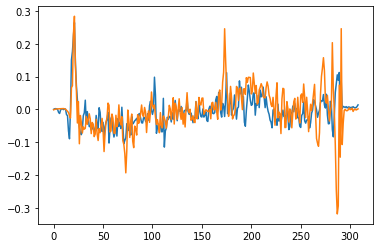

In [34]:
from geometric_operations import *
import matplotlib.pyplot as plt


T_p_gt = np.identity(4)
abs_poses_gt = []
for delta_pose_gt in delta_poses_gt:
    T_p_12 = get_matrix_from_6D_relative_pose(delta_pose_gt[:3], delta_pose_gt[3:])
    T_p_gt = T_p_gt.dot(T_p_12)
    abs_poses_gt.append(get_6D_poses_from_matrix(T_p_gt)[3:])
abs_poses_gt = np.array(abs_poses_gt)

T_p_pred = np.identity(4)
abs_poses_pred = []
for delta_pose_pred in delta_poses_pred:
    T_p_12 = get_matrix_from_6D_relative_pose(delta_pose_pred[:3], delta_pose_pred[3:])
    T_p_pred = T_p_pred.dot(T_p_12)
    abs_poses_pred.append(get_6D_poses_from_matrix(T_p_pred)[3:])
abs_poses_pred = np.array(abs_poses_pred)

plt.plot(delta_poses_pred[:, 5])
plt.plot(delta_poses_gt[:, 5])

plt.plot()
